In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

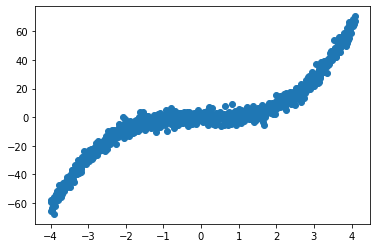

In [7]:
xs = torch.arange(-4., 4.1, 0.01)
rand = torch.empty(xs.shape).normal_(mean=0,std=3.)
ys = xs ** 3 + rand

xs.unsqueeze_(1)
ys.unsqueeze_(1)

plt.scatter(xs, ys)
total_pts = len(xs)

In [8]:
# Functions

from torch.nn import Module
import torch.nn.functional as F

def NIG_NLL(y: torch.Tensor,
            gamma: torch.Tensor,
            nu: torch.Tensor,
            alpha: torch.Tensor,
            beta: torch.Tensor, reduction='mean'):
    twoBlambda = 2*beta*(1+nu)
    nll = 0.5*torch.log(np.pi/nu) - alpha*torch.log(twoBlambda) \
          + (alpha+0.5) * torch.log(nu*(y-gamma)**2 + twoBlambda) \
          + torch.lgamma(alpha)  \
          - torch.lgamma(alpha+0.5)
    return nll.mean()

def NIG_Reg(y, gamma, nu, alpha, reduction='mean'):
    error = (y - gamma).abs()
    evidence = 2. * nu + alpha
    return (error * evidence).mean()

def EvidentialRegression(y: torch.Tensor, evidential_output: torch.Tensor, lmbda=1e-2, eps=0.):
    gamma = evidential_output[0, :]
    nu = evidential_output[1, :]
    alpha = evidential_output[2, :]
    beta = evidential_output[3, :]

    #gamma, nu, alpha, beta = evidential_output
    loss_nll = NIG_NLL(y, gamma, nu, alpha, beta)
    loss_reg = NIG_Reg(y, gamma, nu, alpha)
    return loss_nll + lmbda * (loss_reg - eps)

from torch.nn import Module
import torch.nn.functional as F

class DenseNormalGamma(Module):
    def __init__(self, n_input, n_out_tasks=1):
        super(DenseNormalGamma, self).__init__()
        self.n_in = n_input
        self.n_out = 4 * n_out_tasks
        self.n_tasks = n_out_tasks
        self.l1 = nn.Linear(self.n_in, self.n_out)

    def forward(self, x):
        x = self.l1(x)
        if len(x.shape) == 1:
            gamma, lognu, logalpha, logbeta = torch.split(x, self.n_tasks, dim=0)
        else:
            gamma, lognu, logalpha, logbeta = torch.split(x, self.n_tasks, dim=1)

        nu = F.softplus(lognu)
        alpha = F.softplus(logalpha) + 1.
        beta = F.softplus(logbeta)

        return torch.stack([gamma, nu, alpha, beta]).to(x.device)


In [9]:
from torch import nn

class BasicNetwork(torch.nn.Module):
    def __init__(self, n_in=1, n_tasks=1):
        super(BasicNetwork, self).__init__()
        self.l1 = torch.nn.Linear(n_in, 100)
        self.l2 = torch.nn.Linear(100, 100)
        self.l3 = torch.nn.Linear(100, 100)
        self.l4 = torch.nn.Linear(100, 100)
        self.l5 = DenseNormalGamma(100, 1)
        
    def forward(self, x):
        x = self.l1(x)
        x = torch.nn.functional.relu(x)
        x = self.l2(x)
        x = torch.nn.functional.relu(x)
        x = self.l3(x)
        x = torch.nn.functional.relu(x)
        x = self.l4(x)
        x = torch.nn.functional.relu(x)
        x = self.l5(x)
        return x

In [29]:
epochs = 5000

model = BasicNetwork()
optim = torch.optim.Adam(model.parameters(), lr=5e-3)
#optim = torch.optim.LBFGS(model.parameters(), lr=5e-5)
for epoch in range(epochs):
    def closure():
        output = model(xs)
        loss = EvidentialRegression(ys, output)
        print(f"Step {epoch}: ", loss.item())
        optim.zero_grad()
        loss.backward()
        return loss
    optim.step(closure)

Step 0:  8.918964385986328
Step 1:  7.997960567474365
Step 2:  6.764288902282715
Step 3:  5.3745622634887695
Step 4:  4.2531890869140625
Step 5:  4.939144611358643
Step 6:  5.300715446472168
Step 7:  4.919291973114014
Step 8:  4.346584796905518
Step 9:  4.161234378814697
Step 10:  4.387141227722168
Step 11:  4.548276901245117
Step 12:  4.56380033493042
Step 13:  4.462190628051758
Step 14:  4.28792667388916
Step 15:  4.124917984008789
Step 16:  4.088953971862793
Step 17:  4.176442623138428
Step 18:  4.246702671051025
Step 19:  4.21683406829834
Step 20:  4.110282897949219
Step 21:  4.010761260986328
Step 22:  3.9841856956481934
Step 23:  4.012933731079102
Step 24:  4.0395002365112305
Step 25:  4.028113842010498
Step 26:  3.9761836528778076
Step 27:  3.9065959453582764
Step 28:  3.8552091121673584
Step 29:  3.845231533050537
Step 30:  3.8566596508026123
Step 31:  3.851008176803589
Step 32:  3.8140969276428223
Step 33:  3.7626469135284424
Step 34:  3.725738048553467
Step 35:  3.71281266212

Step 292:  2.625523805618286
Step 293:  2.622784376144409
Step 294:  2.621736764907837
Step 295:  2.6243860721588135
Step 296:  2.623788833618164
Step 297:  2.620387554168701
Step 298:  2.6223206520080566
Step 299:  2.6227293014526367
Step 300:  2.621541738510132
Step 301:  2.620508909225464
Step 302:  2.620415449142456
Step 303:  2.620727062225342
Step 304:  2.6184751987457275
Step 305:  2.617835760116577
Step 306:  2.619018077850342
Step 307:  2.618283987045288
Step 308:  2.617570161819458
Step 309:  2.617265224456787
Step 310:  2.6169352531433105
Step 311:  2.617288589477539
Step 312:  2.6163339614868164
Step 313:  2.61556339263916
Step 314:  2.6159589290618896
Step 315:  2.615717887878418
Step 316:  2.614711046218872
Step 317:  2.614189863204956
Step 318:  2.614433526992798
Step 319:  2.61425518989563
Step 320:  2.613574743270874
Step 321:  2.6126441955566406
Step 322:  2.612248420715332
Step 323:  2.6123621463775635
Step 324:  2.612281560897827
Step 325:  2.6116116046905518
Step 3

Step 570:  2.631237268447876
Step 571:  2.6788923740386963
Step 572:  2.6264874935150146
Step 573:  2.6507911682128906
Step 574:  2.6594393253326416
Step 575:  2.6174378395080566
Step 576:  2.6321585178375244
Step 577:  2.620037794113159
Step 578:  2.6438724994659424
Step 579:  2.6431610584259033
Step 580:  2.627678394317627
Step 581:  2.6555333137512207
Step 582:  2.621656656265259
Step 583:  2.6086997985839844
Step 584:  2.6254050731658936
Step 585:  2.618295669555664
Step 586:  2.6025352478027344
Step 587:  2.6074602603912354
Step 588:  2.614908218383789
Step 589:  2.632540464401245
Step 590:  2.6356024742126465
Step 591:  2.624593496322632
Step 592:  2.6214165687561035
Step 593:  2.64174747467041
Step 594:  2.641782760620117
Step 595:  2.6155731678009033
Step 596:  2.6482093334198
Step 597:  2.682432174682617
Step 598:  2.642990827560425
Step 599:  2.6459364891052246
Step 600:  2.6181771755218506
Step 601:  2.674431085586548
Step 602:  2.6318271160125732
Step 603:  2.63212180137634

Step 857:  2.592158079147339
Step 858:  2.5928008556365967
Step 859:  2.591710329055786
Step 860:  2.5918593406677246
Step 861:  2.591026544570923
Step 862:  2.5920746326446533
Step 863:  2.591766595840454
Step 864:  2.5932962894439697
Step 865:  2.592813491821289
Step 866:  2.5937297344207764
Step 867:  2.592808961868286
Step 868:  2.5925774574279785
Step 869:  2.5918185710906982
Step 870:  2.590895652770996
Step 871:  2.5915491580963135
Step 872:  2.590938091278076
Step 873:  2.5924675464630127
Step 874:  2.5914087295532227
Step 875:  2.593390941619873
Step 876:  2.5921061038970947
Step 877:  2.593550205230713
Step 878:  2.592329502105713
Step 879:  2.5932891368865967
Step 880:  2.5922369956970215
Step 881:  2.592775583267212
Step 882:  2.5923008918762207
Step 883:  2.5923917293548584
Step 884:  2.591529369354248
Step 885:  2.591407299041748
Step 886:  2.59122371673584
Step 887:  2.591043710708618
Step 888:  2.590625286102295
Step 889:  2.5909101963043213
Step 890:  2.590610265731811

Step 1142:  2.585524559020996
Step 1143:  2.585510730743408
Step 1144:  2.585569381713867
Step 1145:  2.585493326187134
Step 1146:  2.585493564605713
Step 1147:  2.585512399673462
Step 1148:  2.5856544971466064
Step 1149:  2.5860626697540283
Step 1150:  2.5869662761688232
Step 1151:  2.5894601345062256
Step 1152:  2.5921592712402344
Step 1153:  2.5983991622924805
Step 1154:  2.5942721366882324
Step 1155:  2.5909969806671143
Step 1156:  2.587165594100952
Step 1157:  2.5867295265197754
Step 1158:  2.5871963500976562
Step 1159:  2.590446710586548
Step 1160:  2.5954222679138184
Step 1161:  2.598612070083618
Step 1162:  2.603544235229492
Step 1163:  2.5962092876434326
Step 1164:  2.5887837409973145
Step 1165:  2.5925607681274414
Step 1166:  2.602288246154785
Step 1167:  2.6353628635406494
Step 1168:  2.6119821071624756
Step 1169:  2.6297433376312256
Step 1170:  2.6380605697631836
Step 1171:  2.6046364307403564
Step 1172:  2.616131544113159
Step 1173:  2.6222264766693115
Step 1174:  2.596328

Step 1429:  2.5865769386291504
Step 1430:  2.591273069381714
Step 1431:  2.588780164718628
Step 1432:  2.588357448577881
Step 1433:  2.5836756229400635
Step 1434:  2.580932140350342
Step 1435:  2.5796937942504883
Step 1436:  2.579862356185913
Step 1437:  2.5814154148101807
Step 1438:  2.5828099250793457
Step 1439:  2.5863077640533447
Step 1440:  2.590177297592163
Step 1441:  2.5989577770233154
Step 1442:  2.588290214538574
Step 1443:  2.5865135192871094
Step 1444:  2.6109812259674072
Step 1445:  2.6251518726348877
Step 1446:  2.6389191150665283
Step 1447:  2.642540693283081
Step 1448:  2.621326208114624
Step 1449:  2.618114709854126
Step 1450:  2.658431053161621
Step 1451:  2.6189184188842773
Step 1452:  2.630887269973755
Step 1453:  2.615387201309204
Step 1454:  2.6211767196655273
Step 1455:  2.640665292739868
Step 1456:  2.607856512069702
Step 1457:  2.620692729949951
Step 1458:  2.6019279956817627
Step 1459:  2.6057021617889404
Step 1460:  2.621212959289551
Step 1461:  2.60049247741

Step 1716:  2.5928609371185303
Step 1717:  2.595398187637329
Step 1718:  2.5949900150299072
Step 1719:  2.584096670150757
Step 1720:  2.5948338508605957
Step 1721:  2.5917246341705322
Step 1722:  2.5868871212005615
Step 1723:  2.5932018756866455
Step 1724:  2.586378574371338
Step 1725:  2.5853021144866943
Step 1726:  2.587977170944214
Step 1727:  2.5852479934692383
Step 1728:  2.582512378692627
Step 1729:  2.58469295501709
Step 1730:  2.5828499794006348
Step 1731:  2.5812339782714844
Step 1732:  2.583137273788452
Step 1733:  2.5830183029174805
Step 1734:  2.580038547515869
Step 1735:  2.5822296142578125
Step 1736:  2.5825390815734863
Step 1737:  2.578549385070801
Step 1738:  2.581122636795044
Step 1739:  2.581376552581787
Step 1740:  2.578451633453369
Step 1741:  2.5808091163635254
Step 1742:  2.5807156562805176
Step 1743:  2.579158306121826
Step 1744:  2.579209804534912
Step 1745:  2.5802364349365234
Step 1746:  2.578091859817505
Step 1747:  2.5782291889190674
Step 1748:  2.5789957046

Step 2001:  2.571528911590576
Step 2002:  2.572997570037842
Step 2003:  2.5716183185577393
Step 2004:  2.572758436203003
Step 2005:  2.572416305541992
Step 2006:  2.5717995166778564
Step 2007:  2.5724358558654785
Step 2008:  2.571990728378296
Step 2009:  2.572676420211792
Step 2010:  2.571450710296631
Step 2011:  2.5722129344940186
Step 2012:  2.57094669342041
Step 2013:  2.5717194080352783
Step 2014:  2.571870803833008
Step 2015:  2.5710744857788086
Step 2016:  2.5720882415771484
Step 2017:  2.571232557296753
Step 2018:  2.5716493129730225
Step 2019:  2.5707173347473145
Step 2020:  2.5715243816375732
Step 2021:  2.571160316467285
Step 2022:  2.571263074874878
Step 2023:  2.5720674991607666
Step 2024:  2.5707855224609375
Step 2025:  2.5716328620910645
Step 2026:  2.571047782897949
Step 2027:  2.570998191833496
Step 2028:  2.571981191635132
Step 2029:  2.5703694820404053
Step 2030:  2.5713050365448
Step 2031:  2.5713016986846924
Step 2032:  2.569837808609009
Step 2033:  2.57083415985107

Step 2278:  2.561823606491089
Step 2279:  2.5619499683380127
Step 2280:  2.5618622303009033
Step 2281:  2.561666250228882
Step 2282:  2.5620808601379395
Step 2283:  2.5637099742889404
Step 2284:  2.564826011657715
Step 2285:  2.5656323432922363
Step 2286:  2.566362142562866
Step 2287:  2.56681752204895
Step 2288:  2.565272092819214
Step 2289:  2.567002534866333
Step 2290:  2.564619302749634
Step 2291:  2.5630760192871094
Step 2292:  2.5617921352386475
Step 2293:  2.5617754459381104
Step 2294:  2.5623764991760254
Step 2295:  2.5619165897369385
Step 2296:  2.563960552215576
Step 2297:  2.565006971359253
Step 2298:  2.5687897205352783
Step 2299:  2.5696182250976562
Step 2300:  2.572631359100342
Step 2301:  2.569638729095459
Step 2302:  2.5631461143493652
Step 2303:  2.563305139541626
Step 2304:  2.5637943744659424
Step 2305:  2.5668811798095703
Step 2306:  2.5707850456237793
Step 2307:  2.57129168510437
Step 2308:  2.5682895183563232
Step 2309:  2.562950849533081
Step 2310:  2.56312441825

Step 2567:  2.5791940689086914
Step 2568:  2.5803468227386475
Step 2569:  2.5754618644714355
Step 2570:  2.5741868019104004
Step 2571:  2.574944257736206
Step 2572:  2.572145462036133
Step 2573:  2.5744094848632812
Step 2574:  2.571476936340332
Step 2575:  2.567873477935791
Step 2576:  2.5710039138793945
Step 2577:  2.5691421031951904
Step 2578:  2.5668296813964844
Step 2579:  2.56813645362854
Step 2580:  2.5666418075561523
Step 2581:  2.566215991973877
Step 2582:  2.5665221214294434
Step 2583:  2.566800355911255
Step 2584:  2.5659639835357666
Step 2585:  2.5654008388519287
Step 2586:  2.566102981567383
Step 2587:  2.5650744438171387
Step 2588:  2.5643341541290283
Step 2589:  2.5646228790283203
Step 2590:  2.563711643218994
Step 2591:  2.5636470317840576
Step 2592:  2.5643627643585205
Step 2593:  2.564854621887207
Step 2594:  2.56321382522583
Step 2595:  2.563647985458374
Step 2596:  2.5645253658294678
Step 2597:  2.563520908355713
Step 2598:  2.5624120235443115
Step 2599:  2.562881708

Step 2849:  2.56101131439209
Step 2850:  2.6028659343719482
Step 2851:  2.6235578060150146
Step 2852:  2.639763832092285
Step 2853:  2.6534085273742676
Step 2854:  2.5963308811187744
Step 2855:  2.653844118118286
Step 2856:  2.656343460083008
Step 2857:  2.6207079887390137
Step 2858:  2.6526541709899902
Step 2859:  2.6078481674194336
Step 2860:  2.6246540546417236
Step 2861:  2.6130731105804443
Step 2862:  2.5912580490112305
Step 2863:  2.6116387844085693
Step 2864:  2.583016872406006
Step 2865:  2.594318151473999
Step 2866:  2.592237949371338
Step 2867:  2.5766894817352295
Step 2868:  2.5951921939849854
Step 2869:  2.5832173824310303
Step 2870:  2.571262836456299
Step 2871:  2.586433172225952
Step 2872:  2.585279941558838
Step 2873:  2.5834672451019287
Step 2874:  2.5767722129821777
Step 2875:  2.573521614074707
Step 2876:  2.593456983566284
Step 2877:  2.6030073165893555
Step 2878:  2.5769152641296387
Step 2879:  2.611923933029175
Step 2880:  2.6142325401306152
Step 2881:  2.58510541

Step 3123:  2.546915054321289
Step 3124:  2.5467793941497803
Step 3125:  2.5465636253356934
Step 3126:  2.546466588973999
Step 3127:  2.5463192462921143
Step 3128:  2.5460636615753174
Step 3129:  2.546088933944702
Step 3130:  2.545875310897827
Step 3131:  2.5456151962280273
Step 3132:  2.5456576347351074
Step 3133:  2.545424699783325
Step 3134:  2.5453555583953857
Step 3135:  2.5454342365264893
Step 3136:  2.5450973510742188
Step 3137:  2.545154571533203
Step 3138:  2.545020580291748
Step 3139:  2.544860601425171
Step 3140:  2.5450937747955322
Step 3141:  2.544619560241699
Step 3142:  2.544848680496216
Step 3143:  2.5445404052734375
Step 3144:  2.544607639312744
Step 3145:  2.5444576740264893
Step 3146:  2.544520854949951
Step 3147:  2.5444085597991943
Step 3148:  2.5442395210266113
Step 3149:  2.544356346130371
Step 3150:  2.5446393489837646
Step 3151:  2.544487237930298
Step 3152:  2.544783353805542
Step 3153:  2.544124126434326
Step 3154:  2.5444698333740234
Step 3155:  2.5448119640

Step 3394:  2.539599895477295
Step 3395:  2.5398194789886475
Step 3396:  2.539681911468506
Step 3397:  2.5393922328948975
Step 3398:  2.538860321044922
Step 3399:  2.539065361022949
Step 3400:  2.53857159614563
Step 3401:  2.5383265018463135
Step 3402:  2.5384764671325684
Step 3403:  2.5375683307647705
Step 3404:  2.5383386611938477
Step 3405:  2.537738800048828
Step 3406:  2.5376200675964355
Step 3407:  2.537876605987549
Step 3408:  2.537308692932129
Step 3409:  2.537200450897217
Step 3410:  2.537173271179199
Step 3411:  2.5374505519866943
Step 3412:  2.537454128265381
Step 3413:  2.537374973297119
Step 3414:  2.53725266456604
Step 3415:  2.537562608718872
Step 3416:  2.536717653274536
Step 3417:  2.5372159481048584
Step 3418:  2.537240505218506
Step 3419:  2.53651762008667
Step 3420:  2.536850929260254
Step 3421:  2.5369081497192383
Step 3422:  2.536379814147949
Step 3423:  2.5361270904541016
Step 3424:  2.5369679927825928
Step 3425:  2.536068916320801
Step 3426:  2.5363311767578125


Step 3676:  2.5329580307006836
Step 3677:  2.5329275131225586
Step 3678:  2.5340983867645264
Step 3679:  2.533601760864258
Step 3680:  2.533202886581421
Step 3681:  2.533939838409424
Step 3682:  2.5327346324920654
Step 3683:  2.532864570617676
Step 3684:  2.534677028656006
Step 3685:  2.534006118774414
Step 3686:  2.5341367721557617
Step 3687:  2.5332071781158447
Step 3688:  2.5334482192993164
Step 3689:  2.5326030254364014
Step 3690:  2.5326333045959473
Step 3691:  2.533857583999634
Step 3692:  2.534788131713867
Step 3693:  2.532487630844116
Step 3694:  2.535818576812744
Step 3695:  2.5340659618377686
Step 3696:  2.5355355739593506
Step 3697:  2.5350868701934814
Step 3698:  2.534219264984131
Step 3699:  2.5332443714141846
Step 3700:  2.5338447093963623
Step 3701:  2.5350534915924072
Step 3702:  2.5347814559936523
Step 3703:  2.532686233520508
Step 3704:  2.5344791412353516
Step 3705:  2.5326037406921387
Step 3706:  2.533794641494751
Step 3707:  2.534970283508301
Step 3708:  2.53251957

Step 3947:  2.5653531551361084
Step 3948:  2.5509586334228516
Step 3949:  2.549170970916748
Step 3950:  2.5594754219055176
Step 3951:  2.5498063564300537
Step 3952:  2.5522685050964355
Step 3953:  2.5537667274475098
Step 3954:  2.540668249130249
Step 3955:  2.5459342002868652
Step 3956:  2.5413658618927
Step 3957:  2.5397133827209473
Step 3958:  2.5478594303131104
Step 3959:  2.5420241355895996
Step 3960:  2.537545680999756
Step 3961:  2.548666000366211
Step 3962:  2.5360171794891357
Step 3963:  2.5381314754486084
Step 3964:  2.5456430912017822
Step 3965:  2.532865285873413
Step 3966:  2.5345358848571777
Step 3967:  2.540236234664917
Step 3968:  2.5307815074920654
Step 3969:  2.5314395427703857
Step 3970:  2.534303903579712
Step 3971:  2.531020402908325
Step 3972:  2.530400037765503
Step 3973:  2.532183885574341
Step 3974:  2.5310535430908203
Step 3975:  2.527322769165039
Step 3976:  2.531552791595459
Step 3977:  2.5282504558563232
Step 3978:  2.5269551277160645
Step 3979:  2.529541492

Step 4230:  2.529226541519165
Step 4231:  2.5289933681488037
Step 4232:  2.5253238677978516
Step 4233:  2.5250635147094727
Step 4234:  2.526279926300049
Step 4235:  2.524768352508545
Step 4236:  2.524101972579956
Step 4237:  2.52396821975708
Step 4238:  2.523955821990967
Step 4239:  2.523029327392578
Step 4240:  2.5228917598724365
Step 4241:  2.522221326828003
Step 4242:  2.5221378803253174
Step 4243:  2.5215699672698975
Step 4244:  2.521111488342285
Step 4245:  2.5212907791137695
Step 4246:  2.520174980163574
Step 4247:  2.5209124088287354
Step 4248:  2.519962787628174
Step 4249:  2.519568920135498
Step 4250:  2.5200865268707275
Step 4251:  2.5199408531188965
Step 4252:  2.519329786300659
Step 4253:  2.5204691886901855
Step 4254:  2.5191221237182617
Step 4255:  2.519374132156372
Step 4256:  2.5191946029663086
Step 4257:  2.519576072692871
Step 4258:  2.518735408782959
Step 4259:  2.5190436840057373
Step 4260:  2.5185861587524414
Step 4261:  2.519127368927002
Step 4262:  2.519062757492

Step 4504:  2.5154125690460205
Step 4505:  2.515949010848999
Step 4506:  2.513960123062134
Step 4507:  2.5141847133636475
Step 4508:  2.514056444168091
Step 4509:  2.5156099796295166
Step 4510:  2.516575336456299
Step 4511:  2.5152525901794434
Step 4512:  2.5182647705078125
Step 4513:  2.5160205364227295
Step 4514:  2.513113021850586
Step 4515:  2.5148391723632812
Step 4516:  2.5146777629852295
Step 4517:  2.512909412384033
Step 4518:  2.5160655975341797
Step 4519:  2.5167837142944336
Step 4520:  2.515936851501465
Step 4521:  2.519726514816284
Step 4522:  2.515124559402466
Step 4523:  2.5156095027923584
Step 4524:  2.5174481868743896
Step 4525:  2.5188663005828857
Step 4526:  2.521808624267578
Step 4527:  2.5181713104248047
Step 4528:  2.5162196159362793
Step 4529:  2.5157833099365234
Step 4530:  2.515899896621704
Step 4531:  2.5203373432159424
Step 4532:  2.518639326095581
Step 4533:  2.5159571170806885
Step 4534:  2.5182600021362305
Step 4535:  2.5172011852264404
Step 4536:  2.513788

Step 4785:  2.5257318019866943
Step 4786:  2.5191314220428467
Step 4787:  2.5324387550354004
Step 4788:  2.531529188156128
Step 4789:  2.526216506958008
Step 4790:  2.526000738143921
Step 4791:  2.535336494445801
Step 4792:  2.523468017578125
Step 4793:  2.5285937786102295
Step 4794:  2.544032573699951
Step 4795:  2.526463270187378
Step 4796:  2.528501033782959
Step 4797:  2.553159475326538
Step 4798:  2.5348246097564697
Step 4799:  2.533855438232422
Step 4800:  2.546229839324951
Step 4801:  2.5245110988616943
Step 4802:  2.5294041633605957
Step 4803:  2.542161226272583
Step 4804:  2.539525270462036
Step 4805:  2.527684211730957
Step 4806:  2.5547573566436768
Step 4807:  2.559004783630371
Step 4808:  2.541367530822754
Step 4809:  2.583350896835327
Step 4810:  2.564399480819702
Step 4811:  2.5629119873046875
Step 4812:  2.560462713241577
Step 4813:  2.5596983432769775
Step 4814:  2.55708646774292
Step 4815:  2.549123764038086
Step 4816:  2.5454180240631104
Step 4817:  2.5481221675872803

In [32]:
# Prediction

y_hat = []
y_aleatoric = []
y_epistemic = []
xs_hat = torch.arange(-6, 6.1, 0.1)
xs_hat.unsqueeze_(1)
ys_hat = xs_hat ** 3
for i, x in enumerate(xs_hat):
    output = model(x)
    gamma, nu, alpha, beta = output
    gamma, nu, alpha, beta = gamma.item(), nu.item(), alpha.item(), beta.item()
    y_hat.append(gamma)
    try:
        y_aleatoric.append((beta/(alpha-1))**0.5)
        y_epistemic.append((beta/(alpha-1)/nu)**0.5)
    except:
        y_aleatoric.append(0.)
        y_epistemic.append(0.)
        print("step x x^3 gamma nu alpha beta")
        print(i, x, x**3, gamma, nu, alpha, beta)
        
y_hat = np.array(y_hat)
y_aleatoric = np.array(y_aleatoric)
y_epistemic = np.array(y_epistemic)

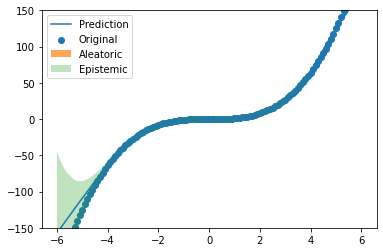

In [33]:
# Plot

plt.plot(xs_hat, y_hat, label='Prediction')
plt.scatter(xs_hat, ys_hat, label='Original')
plt.fill_between(xs_hat[:,0], y_hat-1*y_aleatoric, y_hat+1*y_aleatoric, alpha=0.7, label='Aleatoric')
plt.fill_between(xs_hat[:,0], y_hat-1*y_epistemic, y_hat+1*y_epistemic, alpha=0.3, label='Epistemic')
plt.ylim((-150, 150))
plt.legend()